# Full Vector vs Sliding Window Decoder Delay 

The purpose of this notebook is to demonstrate the ``SlidingWindowDecoder``'s decreased decoding delay, compared to the block based ``FullVectorDecoder``.

By using the ``full_vector_vs_sliding_window.benchmark``, located in the examples folder, we can collect the needed data.
Lets first look at the benchmark code, we use the ``inspect`` for this:

In [1]:
import full_vector_vs_sliding_window
import inspect
print("".join(inspect.getsourcelines(full_vector_vs_sliding_window.benchmark)[0]))


def benchmark(encoder, decoder, channel_condition, data_availablity):
    """Full vector vs sliding window benchmark."""
    # Create some data to encode. In this case we make a buffer
    # with the same size as the encoder's block size (the max.
    # amount a single encoder can encode)
    # Just for fun - fill the input data with random data
    data_in = os.urandom(encoder.block_size())

    # Let's split the data into symbols and feed the encoder one symbol at a
    # time
    symbol_storage = [
        data_in[i:i + encoder.symbol_size()]
        for i in range(0, len(data_in), encoder.symbol_size())
    ]

    results = {}
    ticks = 0
    packet = None
    while not decoder.is_complete():
        ticks += 1
        rank = encoder.rank()
        # Is new data available?
        if rank < encoder.symbols() and random.random() < data_availablity:
            encoder.set_const_symbol(rank, symbol_storage[rank])
            # regardless of the codec we can always send the data sys

As seen from the implementation, the benchmark requires four arguments.
* Encoder,
* Decoder,
* Channel Condition, i.e. the error probability of the channel (both for data and feedback), and finally
* Data delivery which is a value which specifies the likely hood of new data being available.

Lets first create the needed encoders and decoders:

In [2]:
import kodo
import full_vector_vs_sliding_window

symbols = 100
symbol_size = 250

# In the following we will make an encoder/decoder factory.
# The factories are used to build actual encoders/decoders
sliding_window_encoder_factory = kodo.SlidingWindowEncoderFactoryBinary8(
    max_symbols=symbols,
    max_symbol_size=symbol_size)

sliding_window_encoder = sliding_window_encoder_factory.build()

sliding_window_decoder_factory = kodo.SlidingWindowDecoderFactoryBinary8(
    max_symbols=symbols,
    max_symbol_size=symbol_size)

sliding_window_decoder = sliding_window_decoder_factory.build()

full_vector_encoder_factory = kodo.FullVectorEncoderFactoryBinary8(
    max_symbols=symbols,
    max_symbol_size=symbol_size)

full_vector_encoder = full_vector_encoder_factory.build()

full_vector_decoder_factory = kodo.FullVectorDecoderFactoryBinary8(
    max_symbols=symbols,
    max_symbol_size=symbol_size)

full_vector_decoder = full_vector_decoder_factory.build()


Then set the benchmark parameters:

In [3]:
# Set the channel condition
channel_condition = 0.5
# Set data availablity
data_availablity = 0.4

Now that we have all the required information we can run the test.

In [4]:
full_vector_results = full_vector_vs_sliding_window.benchmark(
    full_vector_encoder, full_vector_decoder, channel_condition,
    data_availablity)

sliding_window_results = full_vector_vs_sliding_window.benchmark(
    sliding_window_encoder, sliding_window_decoder, channel_condition,
    data_availablity)

Using matplotlib we can plot the results and get an overview.

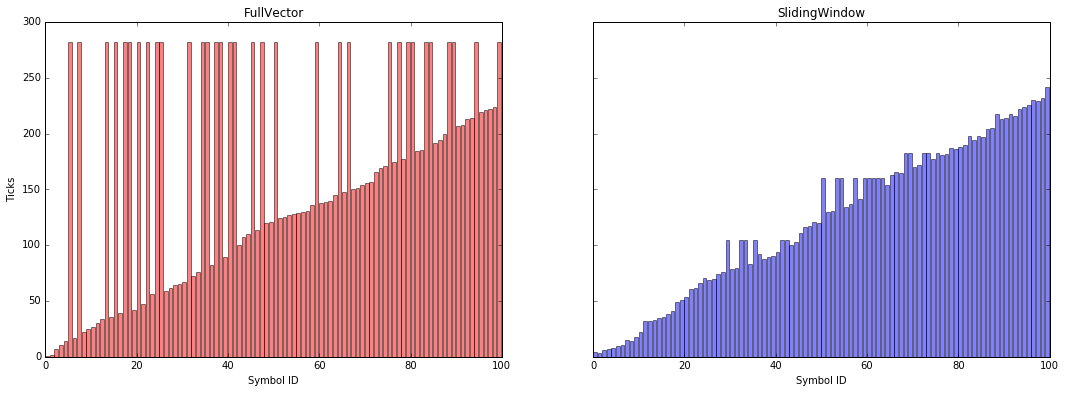

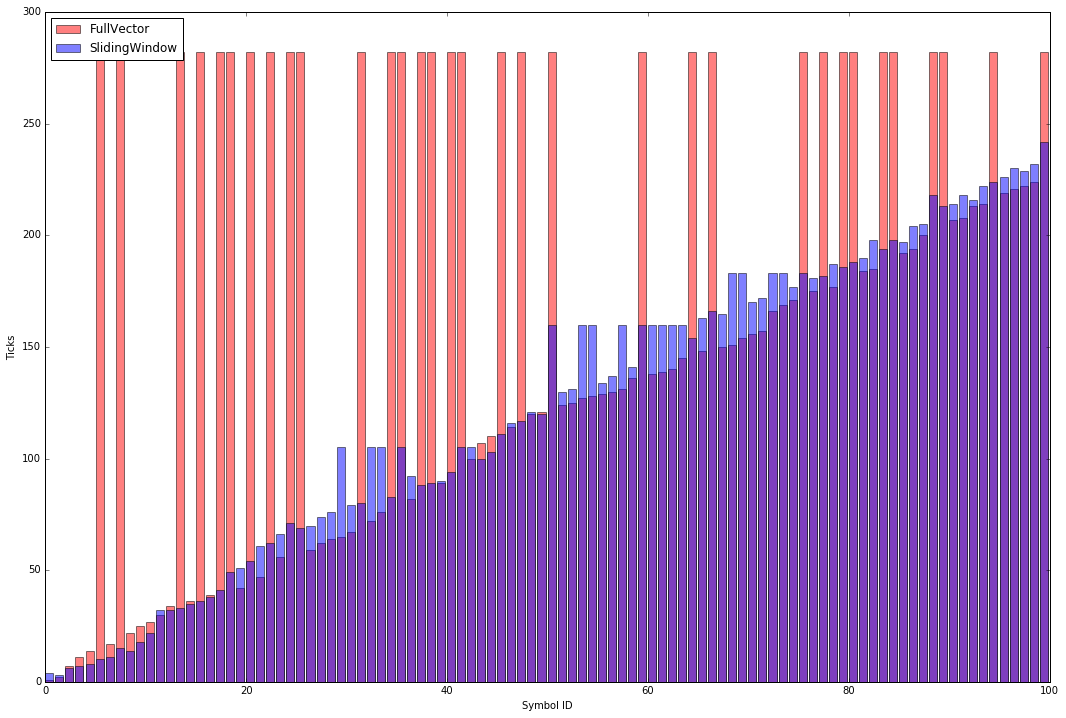

In [5]:
%matplotlib inline
import matplotlib

from matplotlib import pyplot as plt

# split plots
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18, 6), subplot_kw={'ylabel':'Ticks', 'xlabel':'Symbol ID'})
plt.ylabel("")

ax1.set_title("FullVector")
ax1.bar(
    full_vector_results.keys(),
    full_vector_results.values(),
    color='red',
    alpha=0.5)
ax2.set_title("SlidingWindow")
ax2.bar(
    sliding_window_results.keys(),
    sliding_window_results.values(),
    color='blue',
    alpha=0.5)

#single plot

plt.figure(figsize=(18, 12))

plt.xlabel('Symbol ID')
plt.ylabel('Ticks')

plt.bar(
    full_vector_results.keys(),
    full_vector_results.values(),
    color='red',
    alpha=0.5,
    label="FullVector")

plt.bar(
    sliding_window_results.keys(),
    sliding_window_results.values(),
    color='blue',
    alpha=0.5,
    label="SlidingWindow")

plt.legend(loc='best')

pass

From the graph it can be seen that the sliding window codec has an overall lower latency for the whole generation and also for most of the induvidual symbols.